# Predictive Analysis of New York City's Electricity Consumption Using Facebook's Prophet Model for Time Series Forecasting

# Part-1

# Data Preparation

In [3]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv("Electric_Consumption_And_Cost__2010_-_Feb_2023__20231204.csv",low_memory=False)

In [5]:
df.head(3)

,Development Name,Borough,Account Name,Location,Meter AMR,Meter Scope,TDS #,EDP,RC Code,Funding Source,AMP #,Vendor Name,UMIS BILL ID,Revenue Month,Service Start Date,Service End Date,# days,Meter Number,Estimated,Current Charges,Rate Class,Bill Analyzed,Consumption (KWH),KWH Charges,Consumption (KW),KW Charges,Other charges
0,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,NY005001180P,NEW YORK POWER AUTHORITY,1842037,2010-01,12/24/2009,01/26/2010,33.0,7223256,N,15396.82,GOV/NYC/068,Yes,128800.0,7387.97,216.0,2808.0,5200.85
1,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,NY005001180P,NEW YORK POWER AUTHORITY,1844205,2010-02,01/26/2010,02/25/2010,30.0,7223256,N,14556.34,GOV/NYC/068,Yes,115200.0,6607.87,224.0,2912.0,5036.47
2,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,NY005001180P,NEW YORK POWER AUTHORITY,1841378,2010-03,02/25/2010,03/26/2010,29.0,7223256,N,13904.98,GOV/NYC/068,Yes,103200.0,5919.55,216.0,2808.0,5177.43


In [6]:
df = df.sort_values('Revenue Month')

In [7]:
df['Revenue Month'] = pd.to_datetime(df['Revenue Month'])

## Summary Statistics: Dataset Overview

In [8]:
df_m = df[['Borough','Consumption (KWH)','Revenue Month']]

####  Visualization - Plotting Electricity Consumption Over Time - Entire dataset

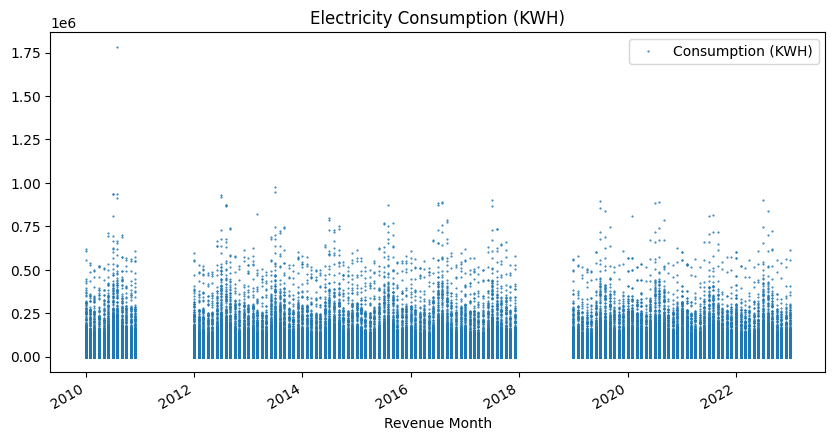

In [9]:
color_pal = sns.color_palette()
df_m.plot(style='.',
         x = 'Revenue Month',
         y='Consumption (KWH)',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='Electricity Consumption (KWH)')
plt.show()

Note: There are a few outliers as per the plot and might be due to special cases such as holidays or other events and the model might learn some pattern here. Also, clearly we can see periodic spikes 

####  Visualization - Plotting Electricity Consumption Over Time - for each borough

In [10]:
def plot_borough(df):
    boroughs = df['Borough'].unique()
    for borough in boroughs:
        borough_df = df[df['Borough'] == borough]
        plt.plot(borough_df['Revenue Month'], borough_df['Consumption (KWH)'], label=borough)
        plt.xlabel('Revenue Month')
        plt.ylabel('Consumption (KWH)')
        plt.title(f'{borough} plot')
        plt.legend()
        plt.show()

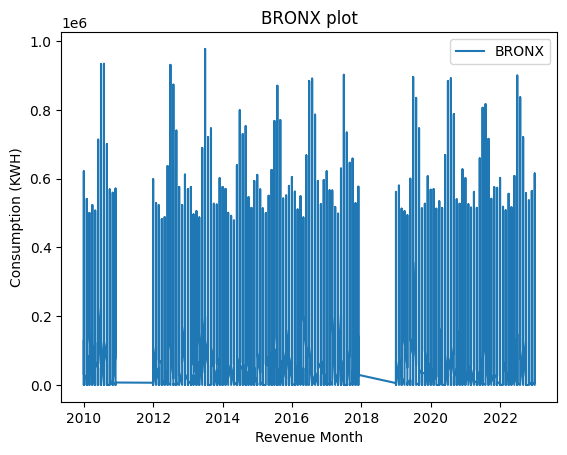

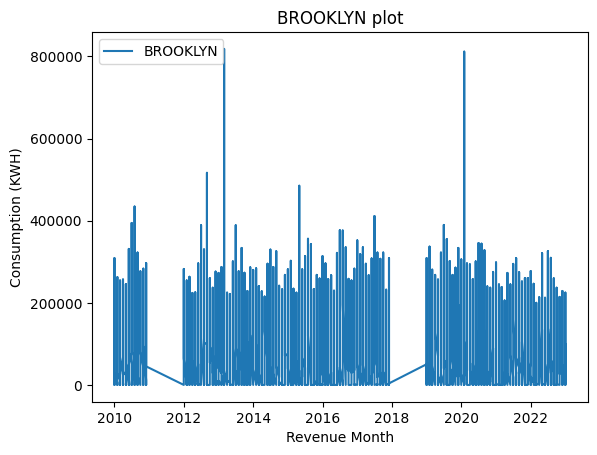

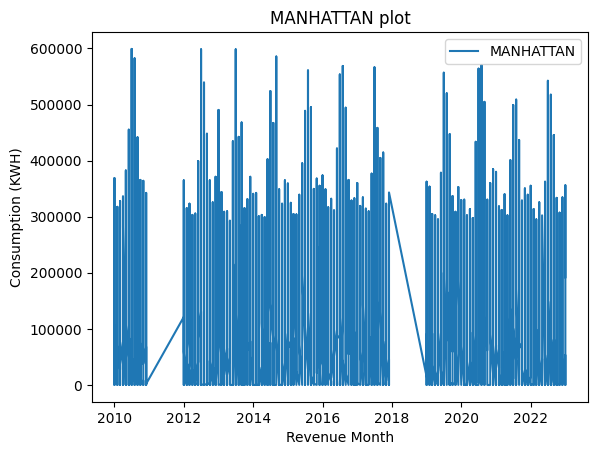

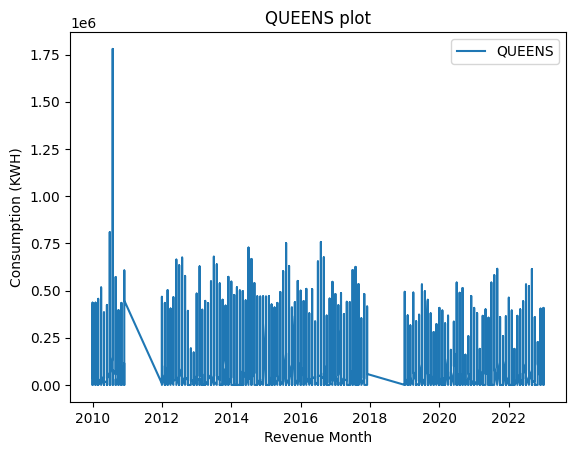

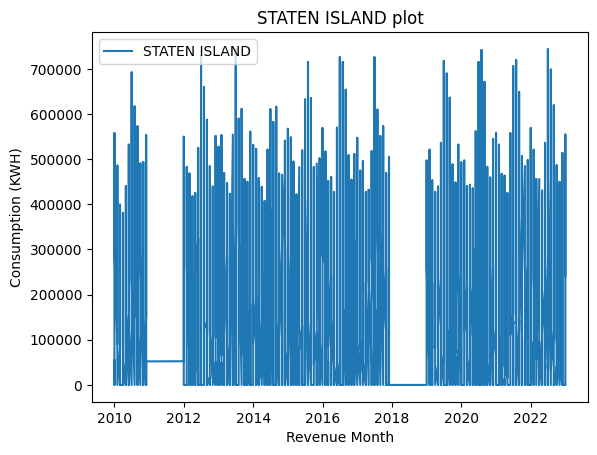

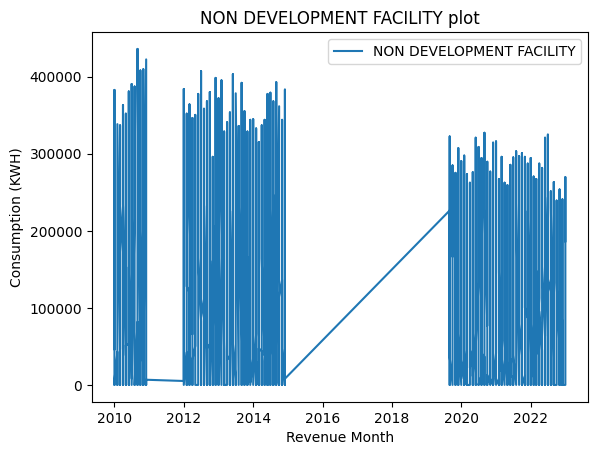

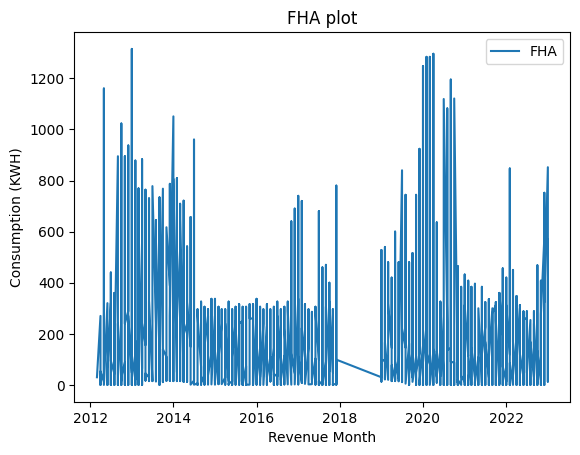

In [11]:
plot_borough(df_m)

Note: The distribution of the consumption across all the Boroughs show a pattern and will be analysing this further ahead.
There are missing values for some durations in the above graphs. 

### Visualizing Monthly Electricity Consumption

In [12]:
x = df_m
x['Month'] = df_m['Revenue Month'].dt.month

/var/folders/lh/cswt7s450g10kh_jxldflrlc0000gn/T/ipykernel_7370/2326848721.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['Month'] = df_m['Revenue Month'].dt.month


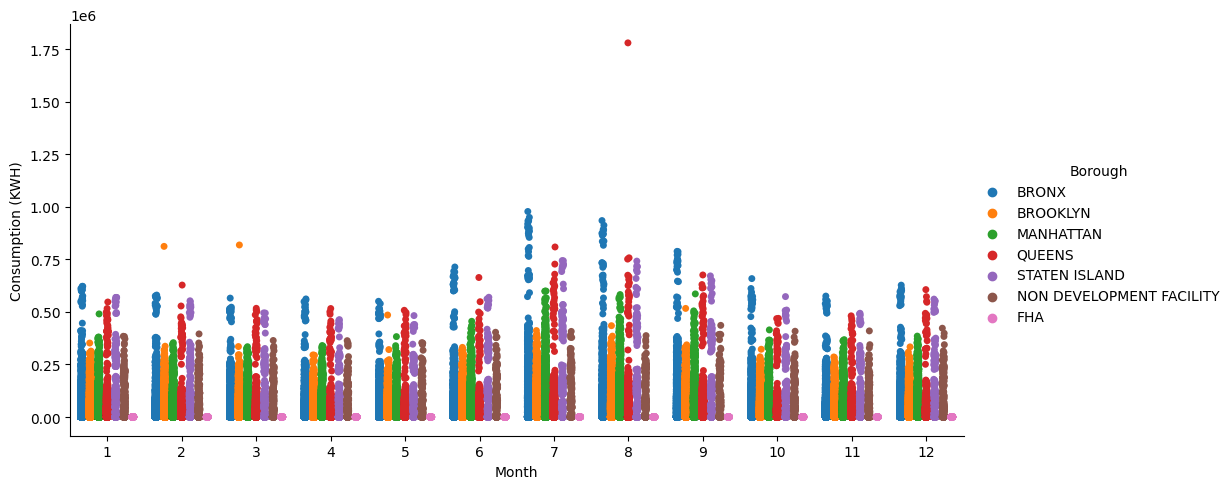

In [13]:
sns.catplot(data=x.dropna(),
            x='Month',
            y='Consumption (KWH)',
            hue = 'Borough',
            dodge=True,
            height=5, aspect=2
           )
plt.show()

Note: Consumption over the months segregated by Boroughs show that the consumption is highest by BRONX, followed by Queens, Staten Island, Manhattan and the least consumption is by Brooklyn. Electricty consumption across all Boroughs increases between July and October, probably due to the Summer

### Consolidation into Single Data Point per Month and its visualization

The mean consumption for each month is calculated by averaging the consumption values across all boroughs for that particular month, resulting in a single data point representing the average consumption for each month.

In [14]:
df_monthly= pd.DataFrame()
df_monthly['ds'] = df_m['Revenue Month']
df_monthly['y'] = df_m[['Consumption (KWH)', 'Revenue Month' ]].groupby('Revenue Month').transform('mean')

In [15]:
df_monthly = df_monthly.drop_duplicates(keep='first')

Text(0.5, 1.0, 'Average Monthly Consumtion over the years')

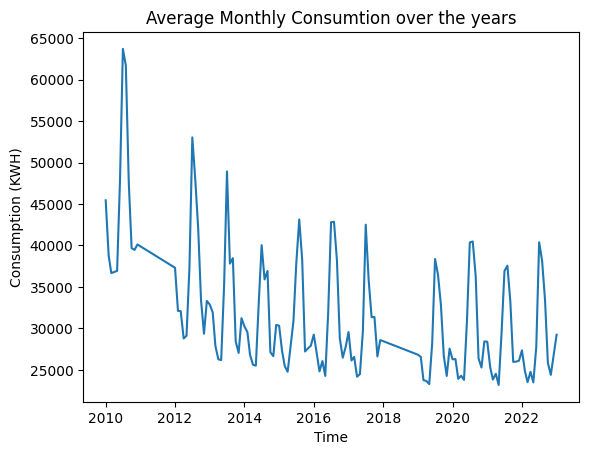

In [16]:
plt.plot( df_monthly['ds'], df_monthly['y'])
plt.xlabel('Time')
plt.ylabel('Consumption (KWH)')
plt.title('Average Monthly Consumtion over the years')

The overall plot here shows that the consumption has reduced since 2012 and shows a periodic pattern ahead. We are ignoring the missing values for 2011 and 2019 for now.

# Part 2

# Model Training and Prediction using the FBProphet module - Default (Linear)

 ### Train Test Split

In [17]:
df_train = df_monthly.loc[df_m['Revenue Month'].dt.year < 2021 ].copy()
df_test = df_monthly.loc[df_m['Revenue Month'].dt.year >= 2021 ].copy()


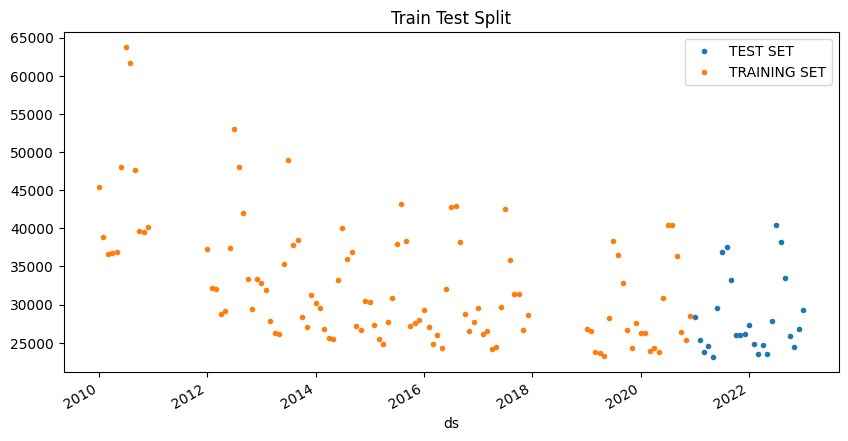

In [18]:
df_test.rename(columns={'y': 'TEST SET'}).merge(df_train.rename(columns={'y': 'TRAINING SET'}),how='outer').plot(figsize=(10, 5), title='Train Test Split', x='ds', style='.')
plt.show()

In [19]:
df_train

,ds,y
0,2010-01-01,45446.030782
29001,2010-02-01,38808.144583
17143,2010-03-01,36667.210941
5210,2010-04-01,36808.514463
18693,2010-05-01,36933.632880
...,...,...
357381,2020-08-01,40483.057185
320783,2020-09-01,36314.894028
362632,2020-10-01,26375.258216
358949,2020-11-01,25281.385157


## Prophet Model - Default

In [20]:
m = Prophet()
m.fit(df_train)
future = m.make_future_dataframe(25, freq='M') #period is in units of days
forecast = m.predict(future)
forecast = m.predict(df_test)
forecast.head(5)

11:04:42 - cmdstanpy - INFO - Chain [1] start processing
11:04:43 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,28555.448989,25012.599543,30163.684630,28555.448989,28555.448989,-1015.161715,-1015.161715,-1015.161715,-1015.161715,-1015.161715,-1015.161715,0.0,0.0,0.0,27540.287274
1,2021-02-01,28524.228189,22454.252641,27736.528132,28519.522504,28529.434169,-3358.763817,-3358.763817,-3358.763817,-3358.763817,-3358.763817,-3358.763817,0.0,0.0,0.0,25165.464372
2,2021-03-01,28496.028757,20487.462331,25540.105472,28483.199951,28509.342812,-5468.005637,-5468.005637,-5468.005637,-5468.005637,-5468.005637,-5468.005637,0.0,0.0,0.0,23028.023121
3,2021-04-01,28464.807957,19562.744209,24847.345571,28440.988044,28486.998049,-6226.598920,-6226.598920,-6226.598920,-6226.598920,-6226.598920,-6226.598920,0.0,0.0,0.0,22238.209037
4,2021-05-01,28434.594280,19655.911270,24870.251692,28393.025575,28468.210670,-6222.532097,-6222.532097,-6222.532097,-6222.532097,-6222.532097,-6222.532097,0.0,0.0,0.0,22212.062183


### Plot showing the Prophet model's forecasted values along with uncertainty intervals.

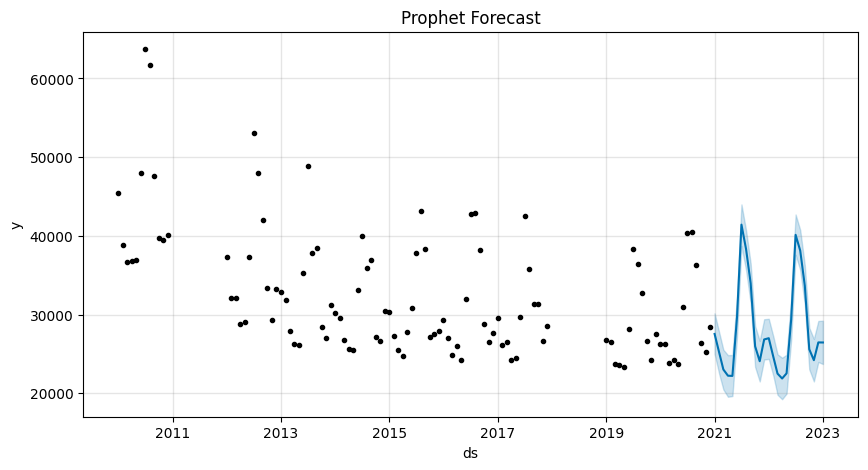

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = m.plot(forecast, ax=ax,uncertainty=True)
ax.set_title('Prophet Forecast')
plt.show()

### Side-by-Side Comparison of Forecasted and Actual Values for Analyzing Predictive Performance

One showing the actual values as red dots ('Actual').
Another showing the predicted values obtained from the forecast ('Predicted').

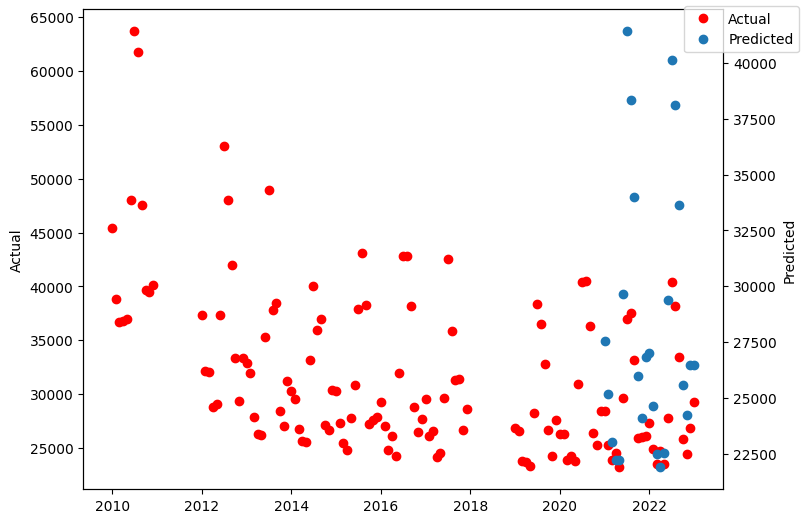

In [22]:
fig = plt.figure()
actual_ax  = fig.add_axes([0,0,1,1])
actual_ax .plot(df_monthly['ds'],df_monthly['y'], 'ro')
actual_ax .set_ylabel('Actual')
predicted_ax = actual_ax .twinx()
predicted_ax.plot(forecast['ds'], forecast['yhat'],'o')
predicted_ax.set_ylabel('Predicted')
fig.legend(labels = ('Actual','Predicted'),loc='upper right')
plt.show()

The model has performed well but it also predicted some outliers might be learnt from the data before 2012

### Visualization of separate components of the time series forecast generated by the Prophet model.

The method m.plot_components(forecast) in the Prophet library generates individual plots for various components of the time series model and its forecast. These components typically include trend, yearly seasonality, weekly seasonality, and any additional custom seasonalities that have been specified or detected by the Prophet model.

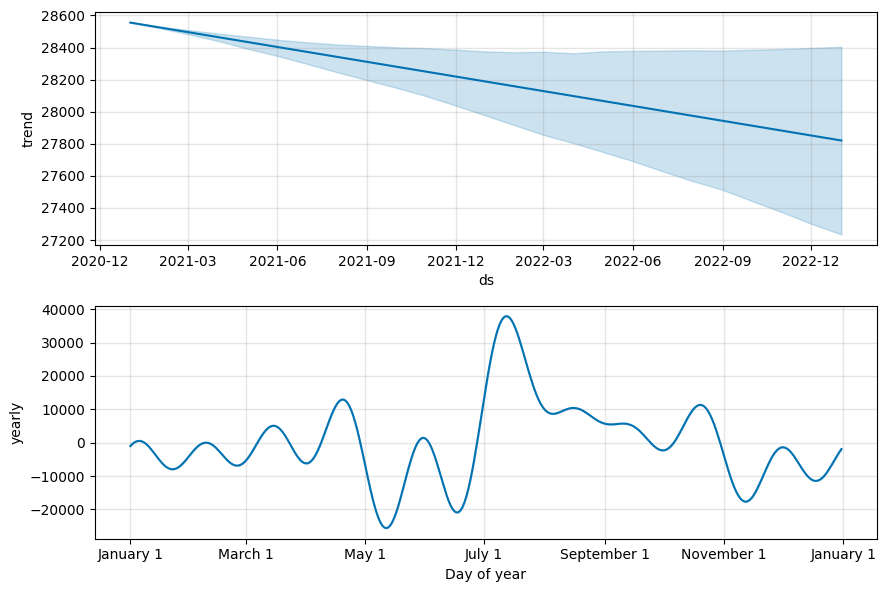

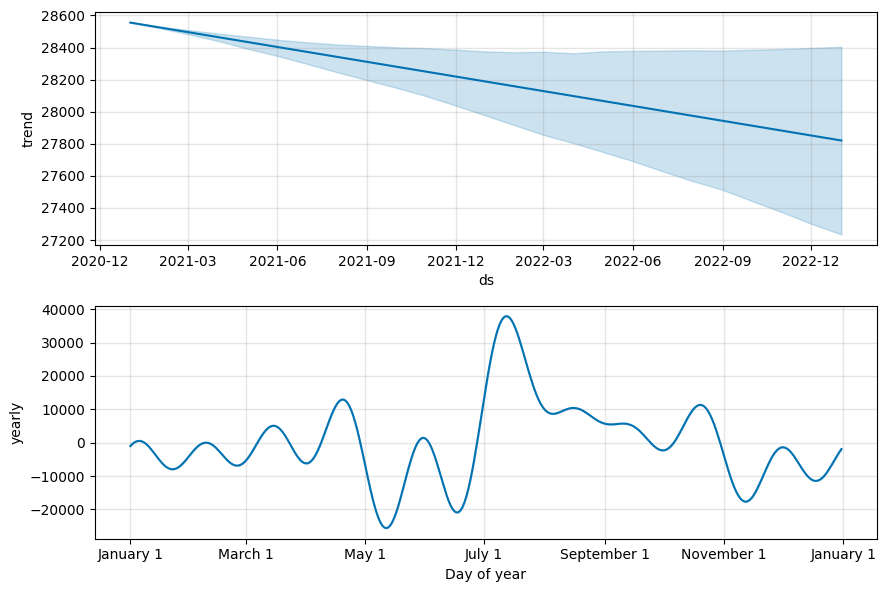

In [23]:
m.plot_components(forecast)

There is a notable increase in consumption typically observed between July and November. This rise in consumption during these months might be attributed to increased usage of air conditioning systems due to warmer weather conditions, suggesting a seasonal pattern corresponding to warmer months.

## Model Evaluation

Calculated and displayed multiple performance metrics to evaluate the accuracy of forecasted values against actual data.

Mean Squared Error (MSE): Evaluates the average squared differences between predicted and actual values.

R-squared Error (R2): Measures the proportion of variance in the dependent variable captured by the model.

Mean Absolute Error (MAE): Computes the average absolute differences between predicted and actual values.

Mean Absolute Percentage Error (MAPE): Determines the average percentage difference between predicted and actual values.

In [24]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print("MSE: ", np.sqrt(mean_squared_error(y_true=df_test['y'], y_pred=forecast['yhat'])))
print("R2 Error: ", r2_score(y_true=df_test['y'], y_pred=forecast['yhat']))
print("MAE: ", mean_absolute_error(y_true=df_test['y'], y_pred=forecast['yhat']))
print("MAPE: ", mean_absolute_percentage_error(y_true=df_test['y'], y_pred=forecast['yhat']))

MSE:  1470.9229983150735
R2 Error:  0.9150950267221416
MAE:  995.7974472620193
MAPE:  3.5682137342746403


Although the absolute error values (MSE, MAE) are relatively higher (1474.07 and 1000.23, respectively), the percentage representation of these errors (MAPE at 3.59%) suggests that, on average, the model's predictions deviate by approximately 3.59% from the actual values.
This indicates that while the actual errors in magnitude might be relatively high, when considering these errors as a percentage of the actual values, they are relatively lower, indicating better performance in relative terms.

# Part 3

# Prophet Model Tuning with Various Parameters

### Logistic Forecasting 

A capacity constraint (cap) of 100000 for both the training and test datasets. 

Plot showing the Prophet model's forecasted values along with uncertainty intervals.

11:04:43 - cmdstanpy - INFO - Chain [1] start processing
11:04:43 - cmdstanpy - INFO - Chain [1] done processing


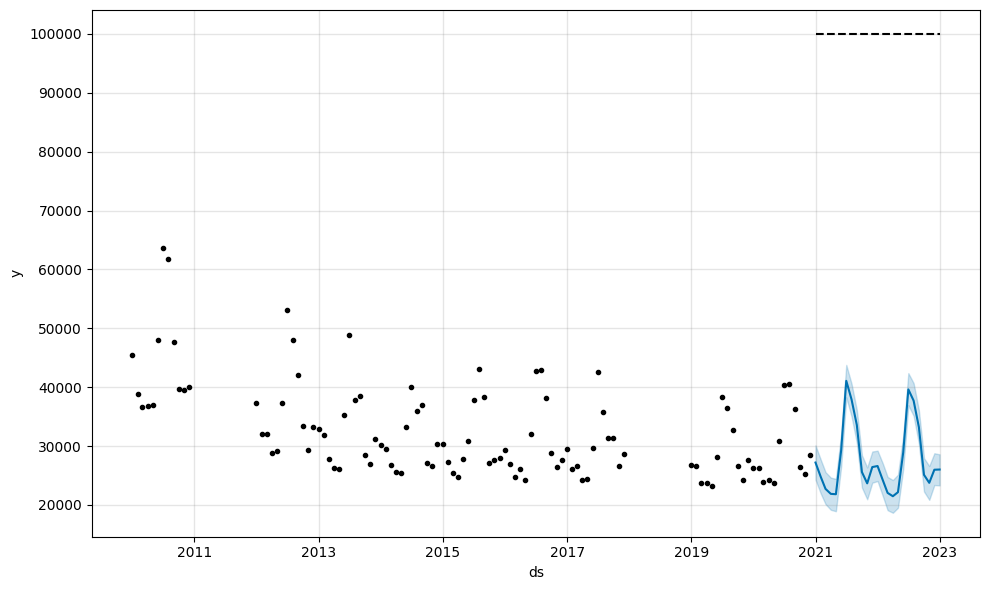

In [25]:
model = Prophet(growth='logistic')
df_train['cap'] = 100000
df_test['cap'] = 100000
model.fit(df_train)
future = model.make_future_dataframe(periods=25, freq = 'M')
future['cap'] = 100000
forecast = model.predict(df_test)
fig = model.plot(forecast)

### Logistic - Side-by-Side Comparison of Forecasted and Actual Values for Analyzing Predictive Performance

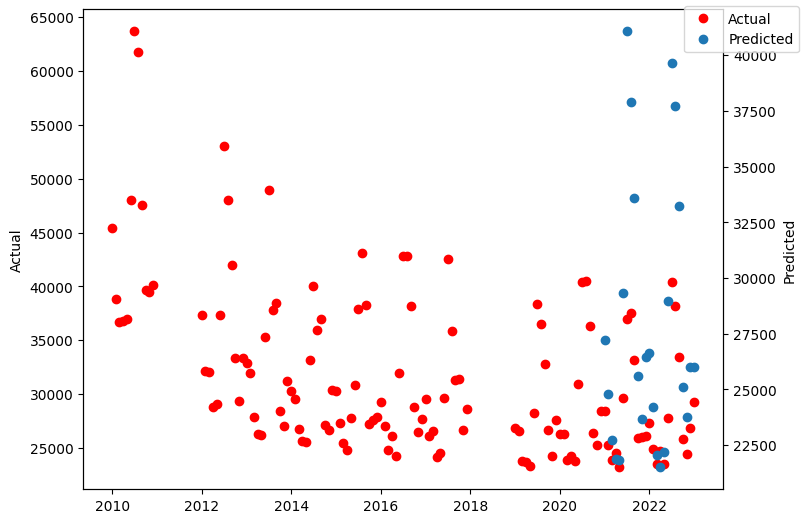

In [26]:
fig = plt.figure()
actual_ax  = fig.add_axes([0,0,1,1])
actual_ax .plot(df_monthly['ds'],df_monthly['y'], 'ro')
actual_ax .set_ylabel('Actual')
predicted_ax = actual_ax .twinx()
predicted_ax.plot(forecast['ds'], forecast['yhat'],'o')
predicted_ax.set_ylabel('Predicted')
fig.legend(labels = ('Actual','Predicted'),loc='upper right')
plt.show()

## Logistic - Model Evaluation

In [27]:
print("MSE: ", np.sqrt(mean_squared_error(y_true=df_test['y'], y_pred=forecast['yhat'])))
print("R2 Error: ", r2_score(y_true=df_test['y'], y_pred=forecast['yhat']))
print("MAE: ", mean_absolute_error(y_true=df_test['y'], y_pred=forecast['yhat']))
print("MAPE: ", mean_absolute_percentage_error(y_true=df_test['y'], y_pred=forecast['yhat']))

MSE:  1605.7201215120597
R2 Error:  0.8988204013925911
MAE:  1217.2010192409055
MAPE:  4.443307882044922


With logistic growth, the model's performance metrics—MSE, MAE, and MAPE—show a slight increase compared to the default setting, indicating a reduction in accuracy and predictive capability.

 ### Flat Forecasting 

11:04:44 - cmdstanpy - INFO - Chain [1] start processing
11:04:44 - cmdstanpy - INFO - Chain [1] done processing


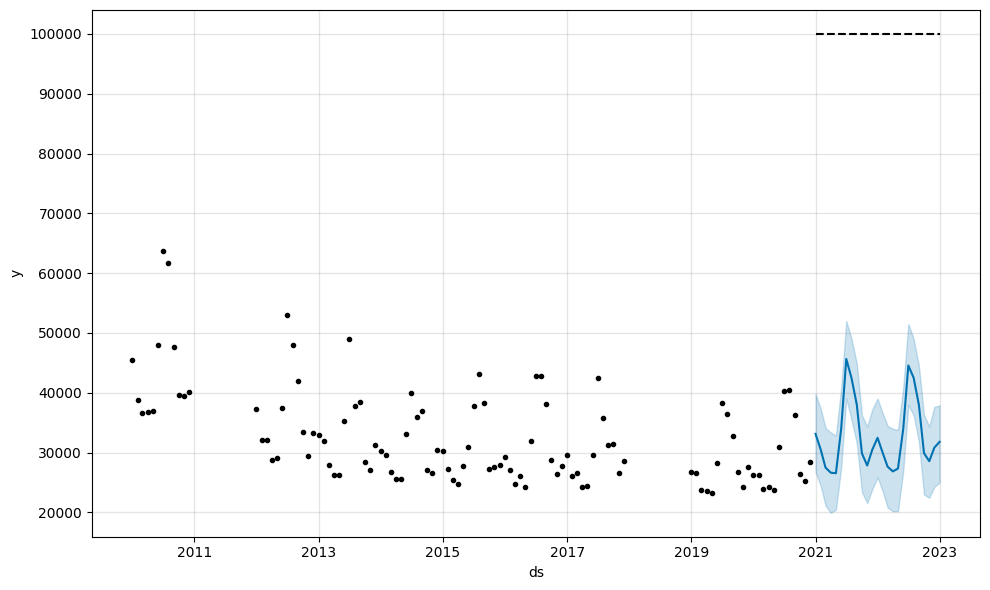

In [28]:
model = Prophet(growth='flat')
df_train['cap'] = 100000
df_test['cap'] = 100000
model.fit(df_train)
future = model.make_future_dataframe(periods=25, freq = 'M')
future['cap'] = 100000
forecast = model.predict(df_test)
fig = model.plot(forecast)

 ### Flat - Side-by-Side Comparison of Forecasted and Actual Values for Analyzing Predictive Performance

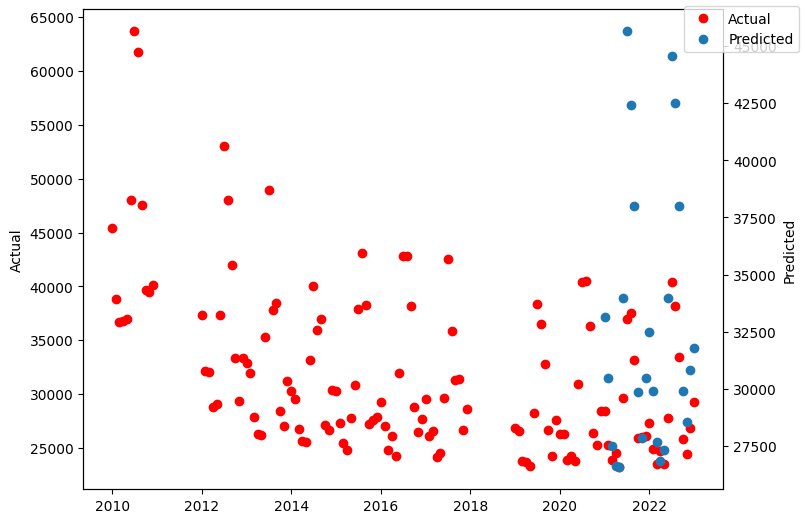

In [29]:
fig = plt.figure()
actual_ax  = fig.add_axes([0,0,1,1])
actual_ax .plot(df_monthly['ds'],df_monthly['y'], 'ro')
actual_ax .set_ylabel('Actual')
predicted_ax = actual_ax .twinx()
predicted_ax.plot(forecast['ds'], forecast['yhat'],'o')
predicted_ax.set_ylabel('Predicted')
fig.legend(labels = ('Actual','Predicted'),loc='upper right')
plt.show()

### Flat - Model Evaluation

In [30]:
print("MSE: ", np.sqrt(mean_squared_error(y_true=df_test['y'], y_pred=forecast['yhat'])))
print("R2 Error: ", r2_score(y_true=df_test['y'], y_pred=forecast['yhat']))
print("MAE: ", mean_absolute_error(y_true=df_test['y'], y_pred=forecast['yhat']))
print("MAPE: ", mean_absolute_percentage_error(y_true=df_test['y'], y_pred=forecast['yhat']))

MSE:  4462.575285627674
R2 Error:  0.21850830912126595
MAE:  4249.6879263484
MAPE:  15.037044651143594


Based on the above metrics, the Flat Prophet model demonstrates worse performance. It has higher errors (MSE, MAE, MAPE)  indicating that it does not fit the data well.

# Prophet Tuned with Fourier Seasonality

In [31]:
m = Prophet()
m.add_seasonality(name="monthly", period=30,fourier_order=2)
m.fit(df_train)
future = m.make_future_dataframe(25, freq='M') #period is in units of months
forecast = m.predict(future)
forecast = model.predict(df_test)
forecast.head(5)

11:04:44 - cmdstanpy - INFO - Chain [1] start processing
11:04:44 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,32336.568199,100000,26581.777168,39564.772469,32336.568199,32336.568199,790.613042,790.613042,790.613042,790.613042,790.613042,790.613042,0.0,0.0,0.0,33127.181241
1,2021-02-01,32336.568199,100000,23865.269571,36454.998931,32336.568199,32336.568199,-1873.712986,-1873.712986,-1873.712986,-1873.712986,-1873.712986,-1873.712986,0.0,0.0,0.0,30462.855213
2,2021-03-01,32336.568199,100000,21225.168454,34604.850578,32336.568199,32336.568199,-4845.876894,-4845.876894,-4845.876894,-4845.876894,-4845.876894,-4845.876894,0.0,0.0,0.0,27490.691305
3,2021-04-01,32336.568199,100000,19999.923635,33258.309761,32336.568199,32336.568199,-5703.496609,-5703.496609,-5703.496609,-5703.496609,-5703.496609,-5703.496609,0.0,0.0,0.0,26633.071590
4,2021-05-01,32336.568199,100000,19993.226451,33205.588048,32336.568199,32336.568199,-5785.246753,-5785.246753,-5785.246753,-5785.246753,-5785.246753,-5785.246753,0.0,0.0,0.0,26551.321447


### Fourier Seasonality - Side-by-Side Comparison of Forecasted and Actual Values for Analyzing Predictive Performance

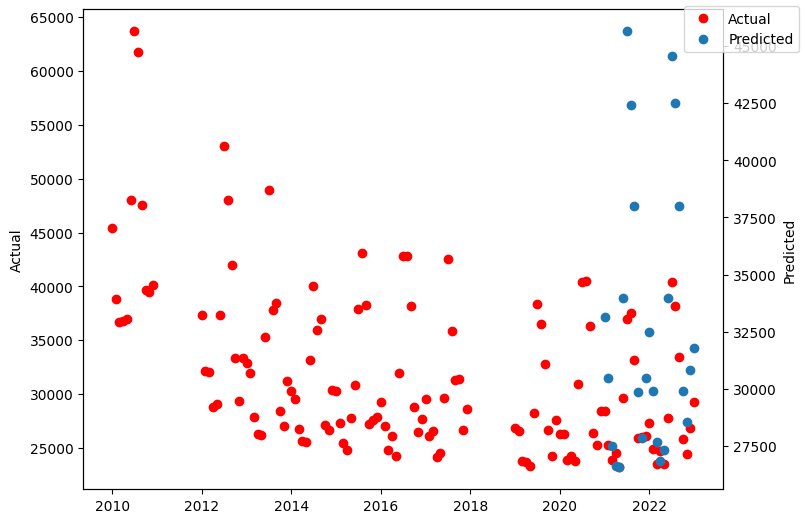

In [32]:
fig = plt.figure()
actual_ax  = fig.add_axes([0,0,1,1])
actual_ax .plot(df_monthly['ds'],df_monthly['y'], 'ro')
actual_ax .set_ylabel('Actual')
predicted_ax = actual_ax .twinx()
predicted_ax.plot(forecast['ds'], forecast['yhat'],'o')
predicted_ax.set_ylabel('Predicted')
fig.legend(labels = ('Actual','Predicted'),loc='upper right')
plt.show()

### Fourier Seasonality - Plot showing the Prophet model's forecasted values along with uncertainty intervals.

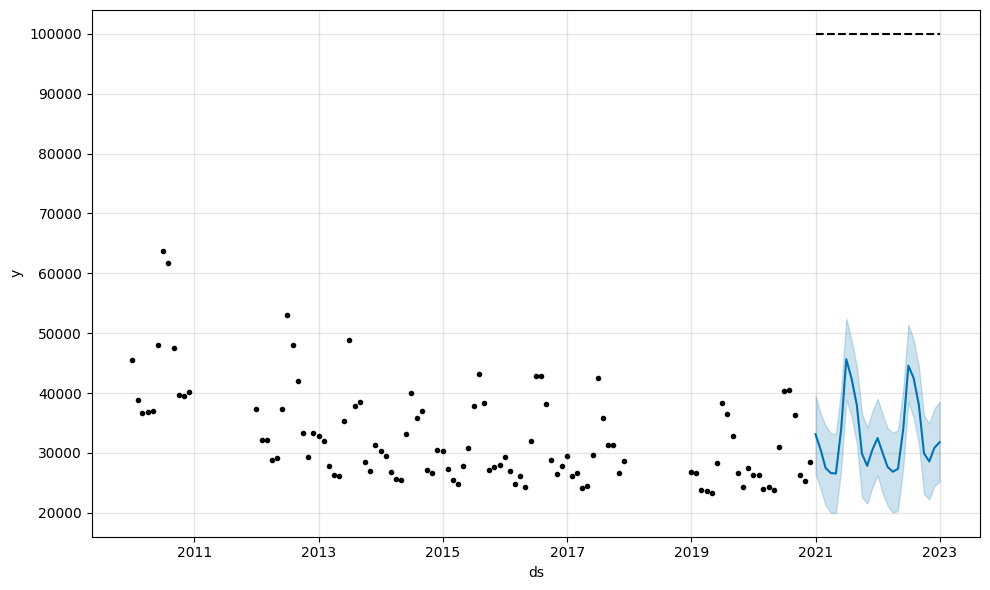

In [33]:
fig = model.plot(forecast)

### Fourier Seasonality - Model Evaluation

In [34]:
print("MSE: ", np.sqrt(mean_squared_error(y_true=df_test['y'], y_pred=forecast['yhat'])))
print("R2 Error: ", r2_score(y_true=df_test['y'], y_pred=forecast['yhat']))
print("MAE: ", mean_absolute_error(y_true=df_test['y'], y_pred=forecast['yhat']))
print("MAPE: ", mean_absolute_percentage_error(y_true=df_test['y'], y_pred=forecast['yhat']))

MSE:  4462.575285627674
R2 Error:  0.21850830912126595
MAE:  4249.6879263484
MAPE:  15.037044651143594


The Fourier seasonality configuration displayed a marginal decline in the R2 error and slight increases in MAE and MAPE.

The observed reduction in forecasting performance suggests that this growth model might not suitably capture the underlying trend or behavior of the dataset, leading to less accurate predictions compared to the default configuration. Further experimentation or refinement may be needed to optimize model performance for the specific dataset and its characteristics.

# Part 4

# Minimizing External Factors in Trend Analysis

### Integration of COVID lockdown_data and Missing Data as Holidays in Time Series Forecasting

In [35]:
lockdown_data = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
    {'holiday': 'missing_data_1', 'ds': '2012-01-01', 'lower_window': 0, 'ds_upper': '2012-12-31'},
    {'holiday': 'missing_data_2', 'ds': '2018-01-01', 'lower_window': 0, 'ds_upper': '2018-12-31'},
])
for t_col in ['ds', 'ds_upper']:
    lockdown_data[t_col] = pd.to_datetime(lockdown_data[t_col])
lockdown_data['upper_window'] = (lockdown_data['ds_upper'] - lockdown_data['ds']).dt.days
lockdown_data

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-21,0,2020-06-06,77
1,lockdown_2,2020-07-09,0,2020-10-27,110
2,lockdown_3,2021-02-13,0,2021-02-17,4
3,lockdown_4,2021-05-28,0,2021-06-10,13
4,missing_data_1,2012-01-01,0,2012-12-31,365
5,missing_data_2,2018-01-01,0,2018-12-31,364


### Plot showing the Prophet model's forecasted values

In [36]:
m2 = Prophet(holidays=lockdown_data)
m2 = m2.fit(df_train)
future = m2.make_future_dataframe(periods=25, freq='M')
forecast = m2.predict(df_test)

11:04:45 - cmdstanpy - INFO - Chain [1] start processing
11:04:45 - cmdstanpy - INFO - Chain [1] done processing


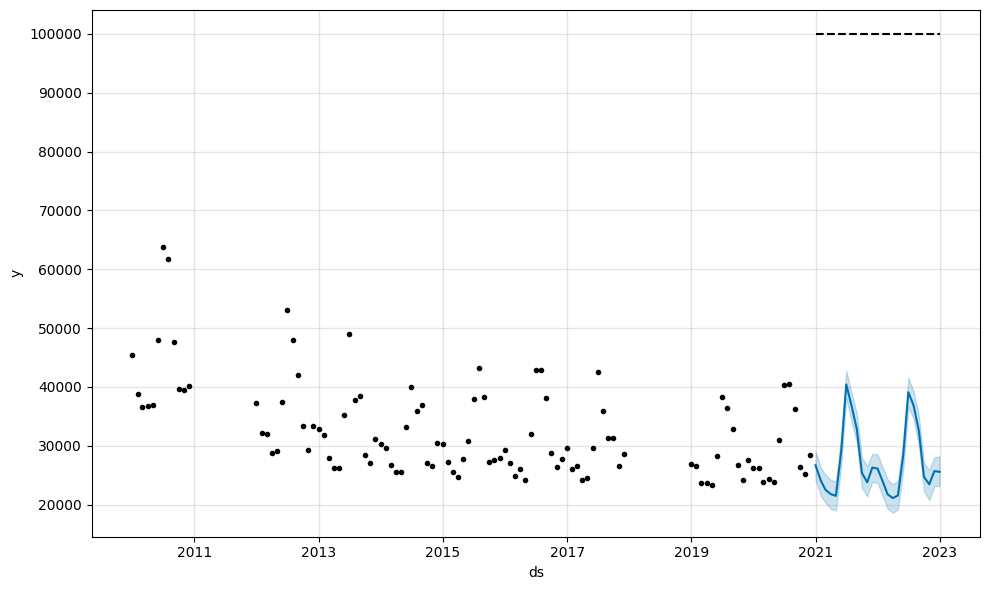

In [37]:
fig = model.plot(forecast)

### Side-by-Side Comparison of Forecasted and Actual Values for Analyzing Predictive Performance

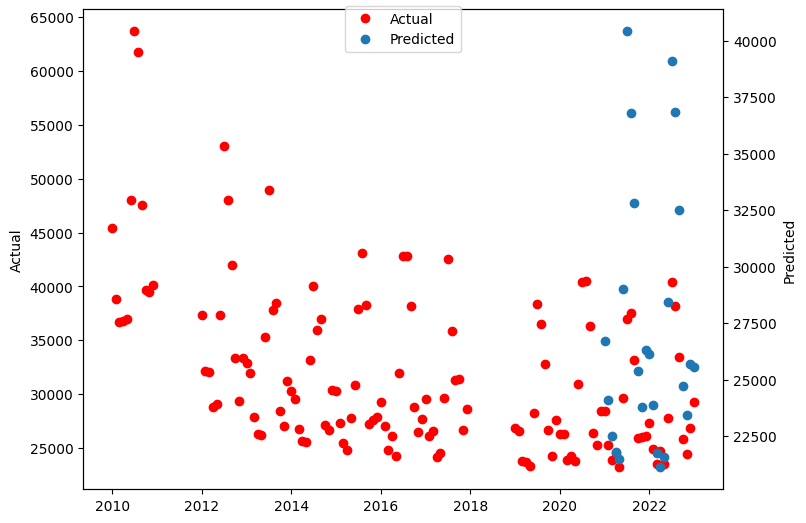

In [38]:
fig = plt.figure()
actual_ax  = fig.add_axes([0,0,1,1])
actual_ax .plot(df_monthly['ds'],df_monthly['y'], 'ro')
actual_ax .set_ylabel('Actual')
predicted_ax = actual_ax .twinx()
predicted_ax.plot(forecast['ds'], forecast['yhat'],'o')
predicted_ax.set_ylabel('Predicted')
fig.legend(labels = ('Actual','Predicted'),loc='upper center')
plt.show()

### Model Evaluation

In [39]:
print("MSE: ", np.sqrt(mean_squared_error(y_true=df_test['y'], y_pred=forecast['yhat'])))
print("R2 Error: ", r2_score(y_true=df_test['y'], y_pred=forecast['yhat']))
print("MAE: ", mean_absolute_error(y_true=df_test['y'], y_pred=forecast['yhat']))
print("MAPE: ", mean_absolute_percentage_error(y_true=df_test['y'], y_pred=forecast['yhat']))

MSE:  1775.9926397787438
R2 Error:  0.8762242472618704
MAE:  1494.3645868535882
MAPE:  5.44207448026023


Note: While the model that includes COVID lockdown_data and missing data as holidays isn't the most accurate for predicting outcomes, its higher errors indicate that adding these events as holidays might have made the predictions less precise. Despite this, it's considered important to include these holidays because it helps the model better adapt to future trends or patterns influenced by these events, even though it might not perform as well when looking at past data.

# Part 5

# Utilizing Linear Model with Holiday Dataset for Future Predictions

##### When the time unit corresponds to a month, the forecasting model is designed to predict the Electric Consumption (EC) values for future periods, specifically for intervals of 1, 6, and 9 months ahead.

11:04:45 - cmdstanpy - INFO - Chain [1] start processing
11:04:45 - cmdstanpy - INFO - Chain [1] done processing


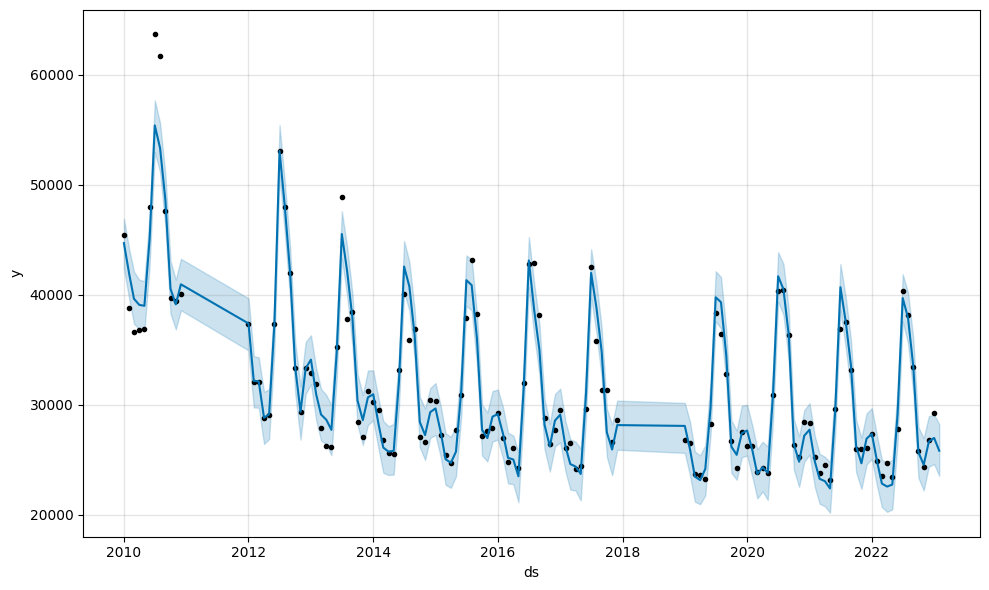

In [40]:
m = Prophet(holidays=lockdown_data)
m = m.fit(df_monthly)
future = m.make_future_dataframe(periods=1, freq='M') #period is in units of Months
forecast = m.predict(future)
m.plot(forecast);

11:04:46 - cmdstanpy - INFO - Chain [1] start processing
11:04:46 - cmdstanpy - INFO - Chain [1] done processing


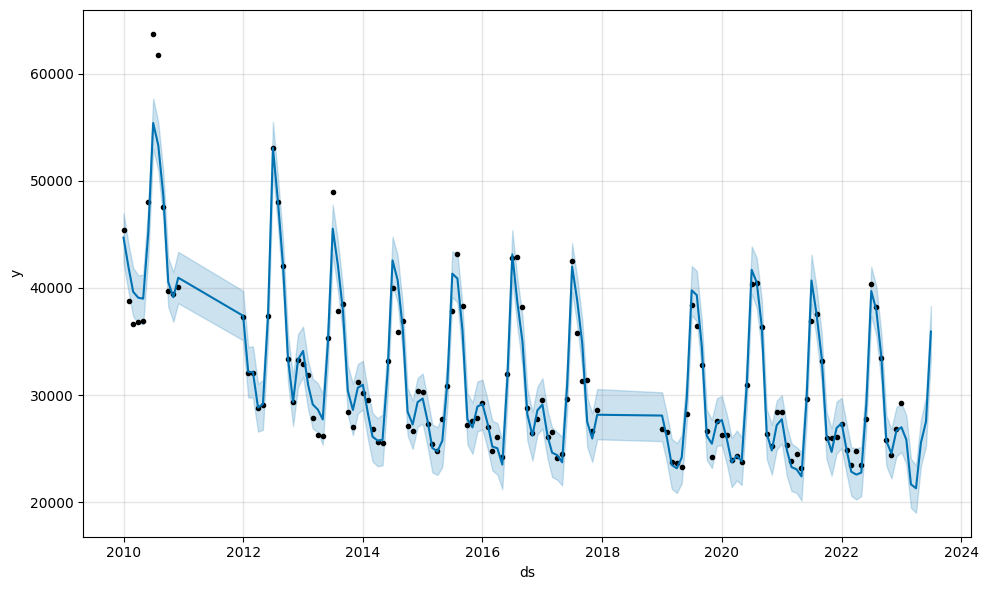

In [41]:
m = Prophet(holidays=lockdown_data)
m = m.fit(df_monthly)
future = m.make_future_dataframe(periods=6, freq='M') #period is in units of Months
forecast = m.predict(future)
m.plot(forecast);

11:04:46 - cmdstanpy - INFO - Chain [1] start processing
11:04:46 - cmdstanpy - INFO - Chain [1] done processing


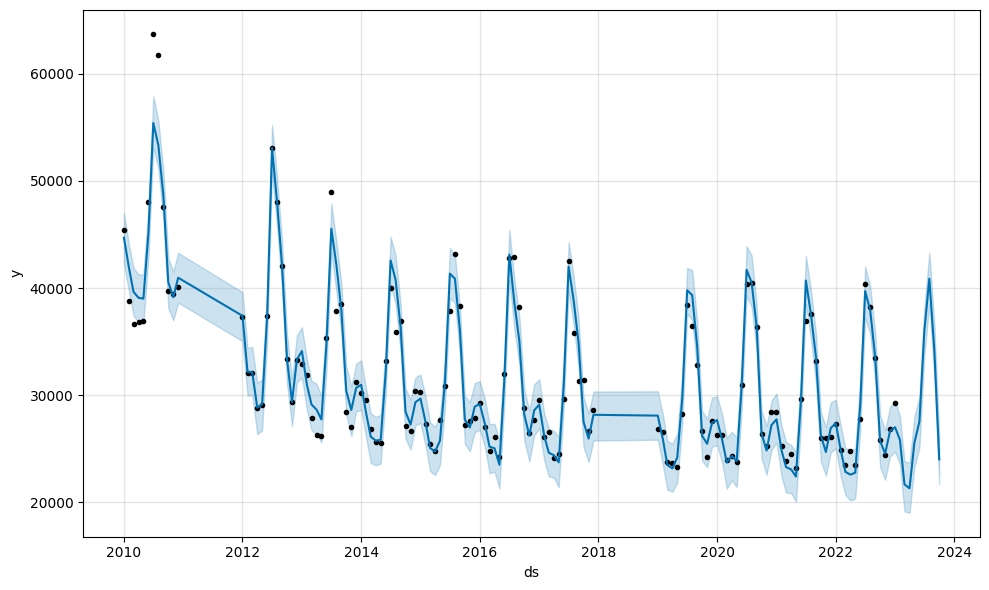

In [42]:
m = Prophet(holidays=lockdown_data)
m = m.fit(df_monthly)
future = m.make_future_dataframe(periods=9, freq='M') #period is in units of Months
forecast = m.predict(future)
m.plot(forecast);

##### When the time unit is measured in years, the forecasting model predicts the Electricity Consumption (EC) values for future periods spanning 1, 10, or 20 years ahead.

Calculated yearly average consumption, arranging it by year ('ds') and consumption ('y') for time series analysis using pandas functions and datetime formatting.

In [43]:
df_yearly = df[['Consumption (KWH)', 'Revenue Month']]
df_yearly['avg_by_year'] = df.groupby(df['Revenue Month'].dt.year)['Consumption (KWH)'].transform('mean')
df_yearly['Year'] = df_yearly['Revenue Month'].dt.year
df_yearly = df_yearly[['avg_by_year','Year']]
df_yearly.columns = ['y','ds']
df_yearly = df_yearly.drop_duplicates(keep='first').reset_index(drop=True)
df_yearly['ds'] = pd.to_datetime(df_yearly['ds'], format='%Y')

/var/folders/lh/cswt7s450g10kh_jxldflrlc0000gn/T/ipykernel_7370/1124623150.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yearly['avg_by_year'] = df.groupby(df['Revenue Month'].dt.year)['Consumption (KWH)'].transform('mean')
/var/folders/lh/cswt7s450g10kh_jxldflrlc0000gn/T/ipykernel_7370/1124623150.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yearly['Year'] = df_yearly['Revenue Month'].dt.year


In [44]:
df_yearly

,y,ds
0,44612.137796,2010-01-01
1,36346.207317,2012-01-01
2,32702.755515,2013-01-01
3,30694.267709,2014-01-01
4,30726.874515,2015-01-01
5,30849.120661,2016-01-01
6,29747.362545,2017-01-01
7,28191.254194,2019-01-01
8,28353.656726,2020-01-01
9,28162.642161,2021-01-01


11:04:47 - cmdstanpy - INFO - Chain [1] start processing
11:04:47 - cmdstanpy - INFO - Chain [1] done processing


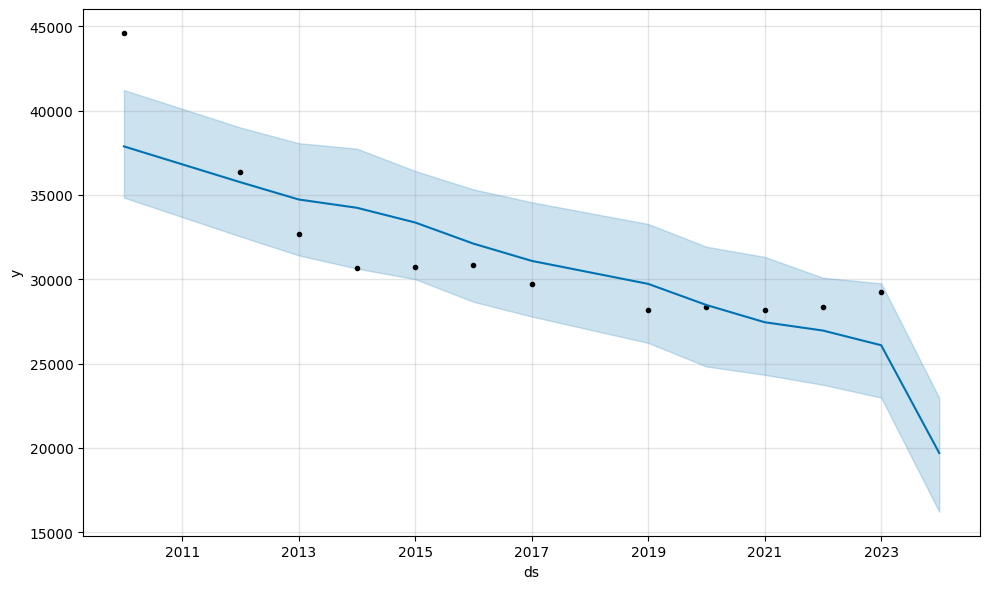

In [45]:
m = Prophet()
m = m.fit(df_yearly)
future = m.make_future_dataframe(periods=1, freq='Y') #period is in units of Years
forecast = m.predict(future)
m.plot(forecast);

11:04:47 - cmdstanpy - INFO - Chain [1] start processing


11:04:47 - cmdstanpy - INFO - Chain [1] done processing


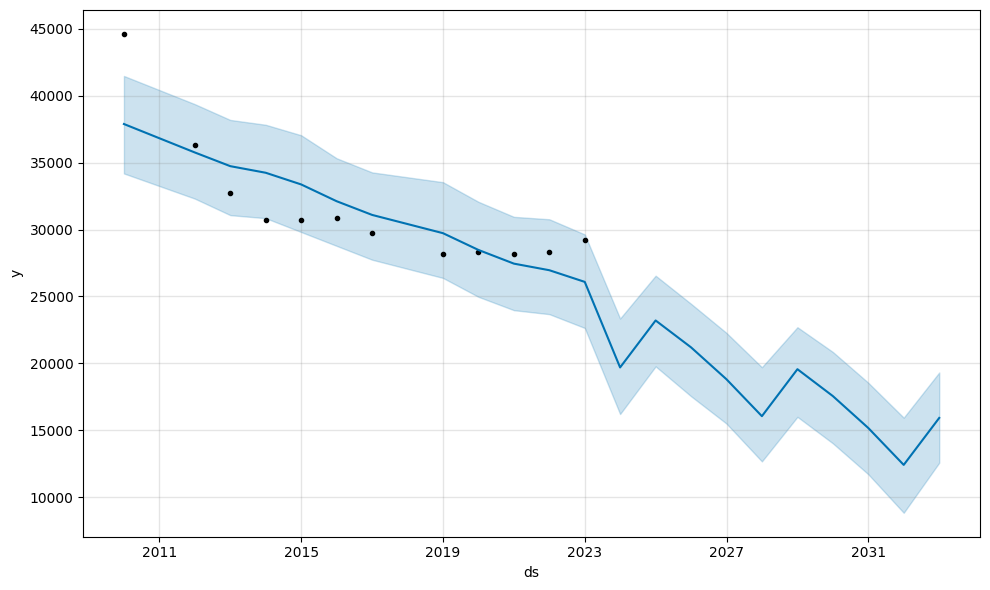

In [46]:
m = Prophet()
m = m.fit(df_yearly)
future = m.make_future_dataframe(periods=10, freq='Y') #period is in units of Years
forecast = m.predict(future)
m.plot(forecast);

11:04:48 - cmdstanpy - INFO - Chain [1] start processing
11:05:08 - cmdstanpy - INFO - Chain [1] done processing


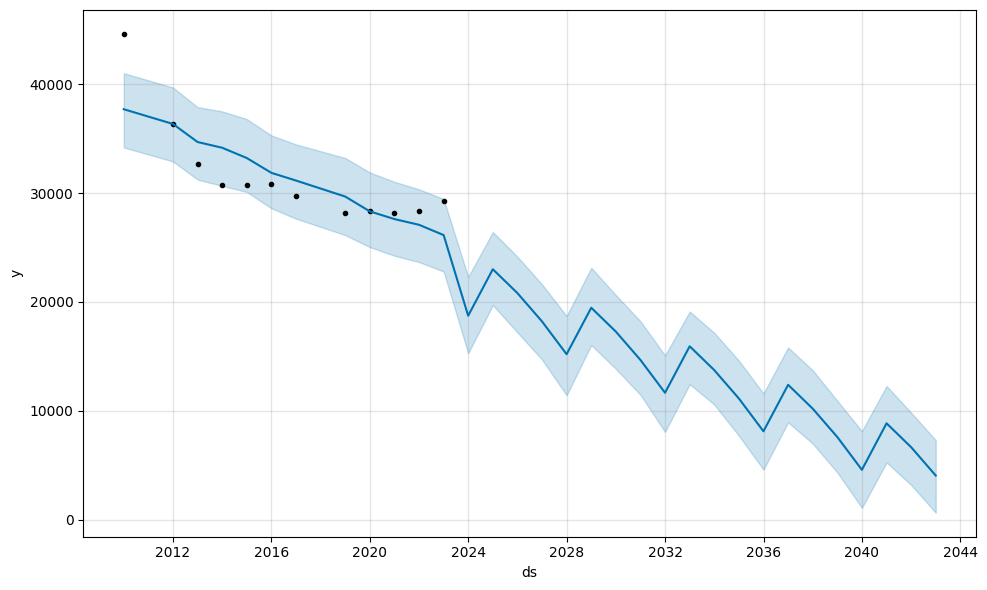

In [47]:
m = Prophet(holidays=lockdown_data)
m = m.fit(df_yearly)
future = m.make_future_dataframe(periods=20, freq='Y') #period is in units of Years
forecast = m.predict(future)
m.plot(forecast);

### Employing yearly mean data yields a declining trend without noticeable patterns for the model to learn. To highlight the disparity, we'll used monthly data for the equivalent predictions.

11:05:09 - cmdstanpy - INFO - Chain [1] start processing
11:05:09 - cmdstanpy - INFO - Chain [1] done processing


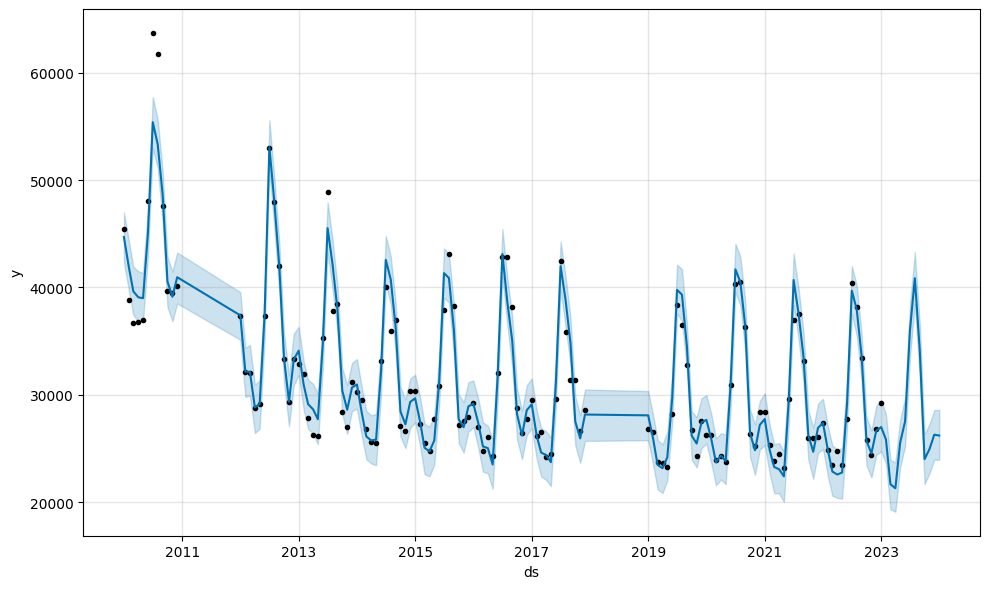

In [48]:
m = Prophet(holidays=lockdown_data)
m = m.fit(df_monthly)
future = m.make_future_dataframe(periods=12, freq='M') #period is in units of Months
forecast = m.predict(future)
m.plot(forecast);

11:05:09 - cmdstanpy - INFO - Chain [1] start processing
11:05:10 - cmdstanpy - INFO - Chain [1] done processing


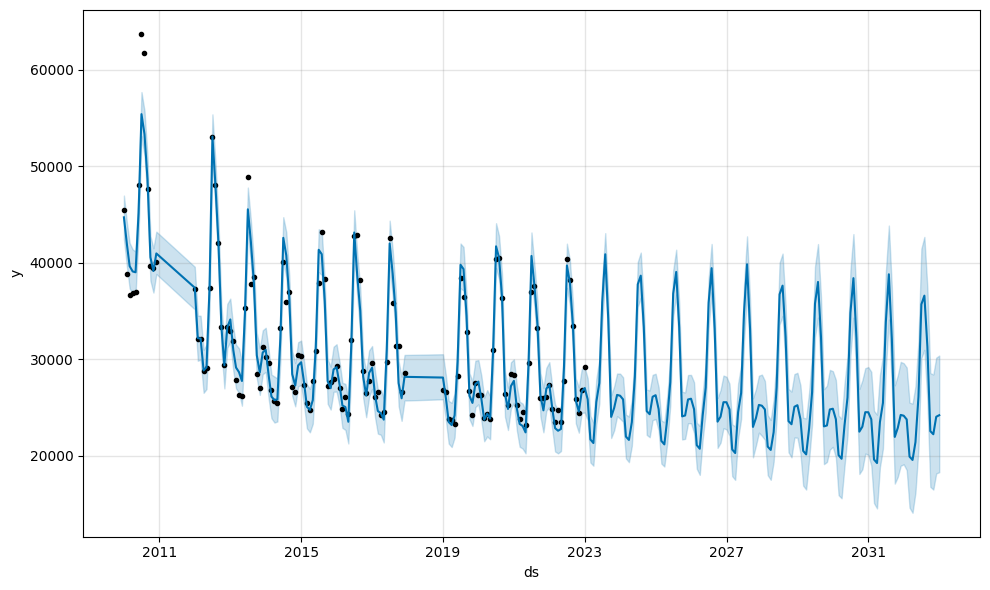

In [49]:
m = Prophet(holidays=lockdown_data)
m = m.fit(df_monthly)
future = m.make_future_dataframe(periods=12*10, freq='M') #period is in units of Months
forecast = m.predict(future)
m.plot(forecast);

11:05:10 - cmdstanpy - INFO - Chain [1] start processing
11:05:10 - cmdstanpy - INFO - Chain [1] done processing


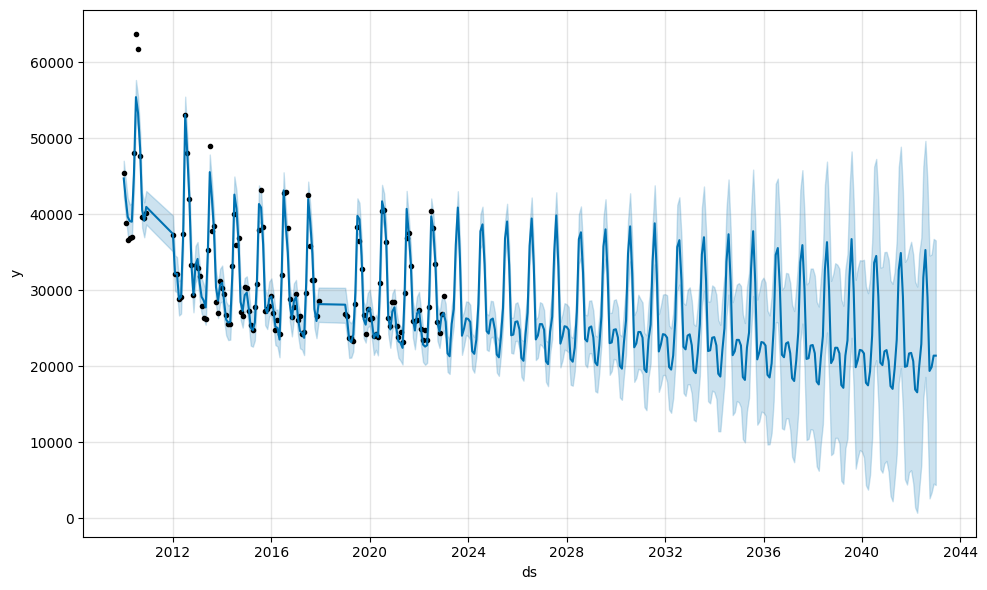

In [50]:
m = Prophet(holidays=lockdown_data)
m = m.fit(df_monthly)
future = m.make_future_dataframe(periods=12*20, freq='M') #period is in units of Months
forecast = m.predict(future)
m.plot(forecast);

The future predictions look much better now with monthly mean data. Also the holiday parameter has helped to avoid covid and missing data trends in the future prediction

# Part 6

# Electric Consumption Prediction for Individual Boroughs

#### For 3 years

Computed the mean consumption ('y') for each borough and associates it with the respective revenue month ('ds'). It then organizes this information into a DataFrame, linking consumption data ('y') with revenue months ('ds') and boroughs for analysis.

In [51]:
df_borough = pd.DataFrame()
df_borough['y'] = df[['Borough','Revenue Month','Consumption (KWH)']].groupby(['Borough','Revenue Month']).transform('mean')
df_borough['ds'] = df['Revenue Month']
df_borough['Borough'] = df['Borough']

In [52]:
df_borough = df_borough.reset_index(drop=True)

In [53]:
df_borough

,y,ds,Borough
0,50028.041121,2010-01-01,BRONX
1,37531.571903,2010-01-01,BROOKLYN
2,37531.571903,2010-01-01,BROOKLYN
3,37531.571903,2010-01-01,BROOKLYN
4,37531.571903,2010-01-01,BROOKLYN
...,...,...,...
447844,34826.816393,2023-01-01,BRONX
447845,34826.816393,2023-01-01,BRONX
447846,34826.816393,2023-01-01,BRONX
447847,22148.070295,2023-01-01,BROOKLYN


11:05:11 - cmdstanpy - INFO - Chain [1] start processing
11:05:11 - cmdstanpy - INFO - Chain [1] done processing
11:05:11 - cmdstanpy - INFO - Chain [1] start processing
11:05:11 - cmdstanpy - INFO - Chain [1] done processing
11:05:12 - cmdstanpy - INFO - Chain [1] start processing
11:05:12 - cmdstanpy - INFO - Chain [1] done processing
11:05:12 - cmdstanpy - INFO - Chain [1] start processing
11:05:12 - cmdstanpy - INFO - Chain [1] done processing
11:05:13 - cmdstanpy - INFO - Chain [1] start processing
11:05:13 - cmdstanpy - INFO - Chain [1] done processing


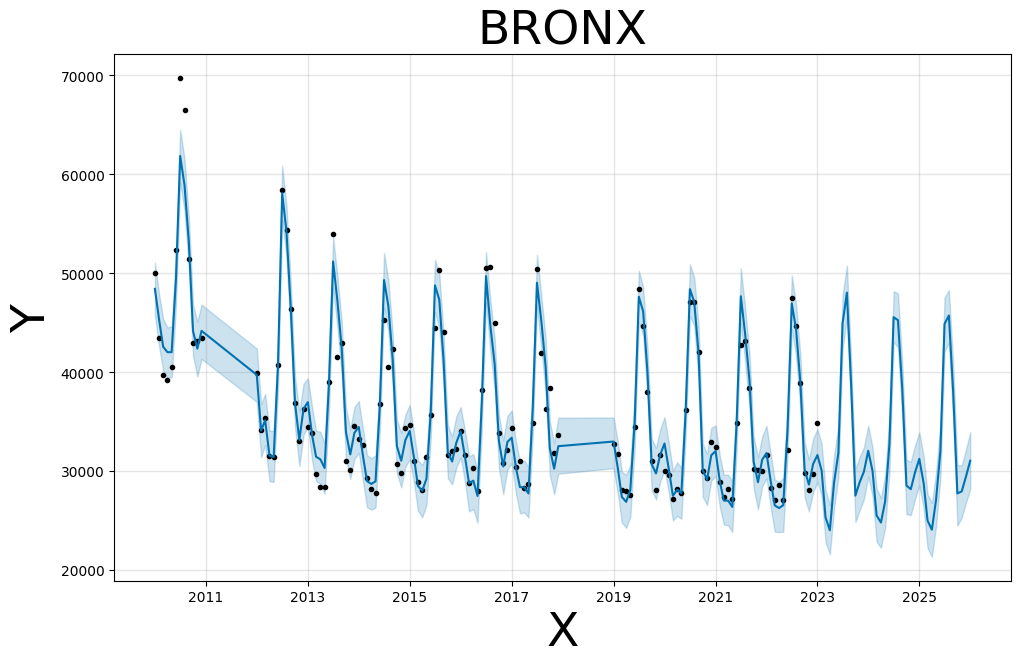

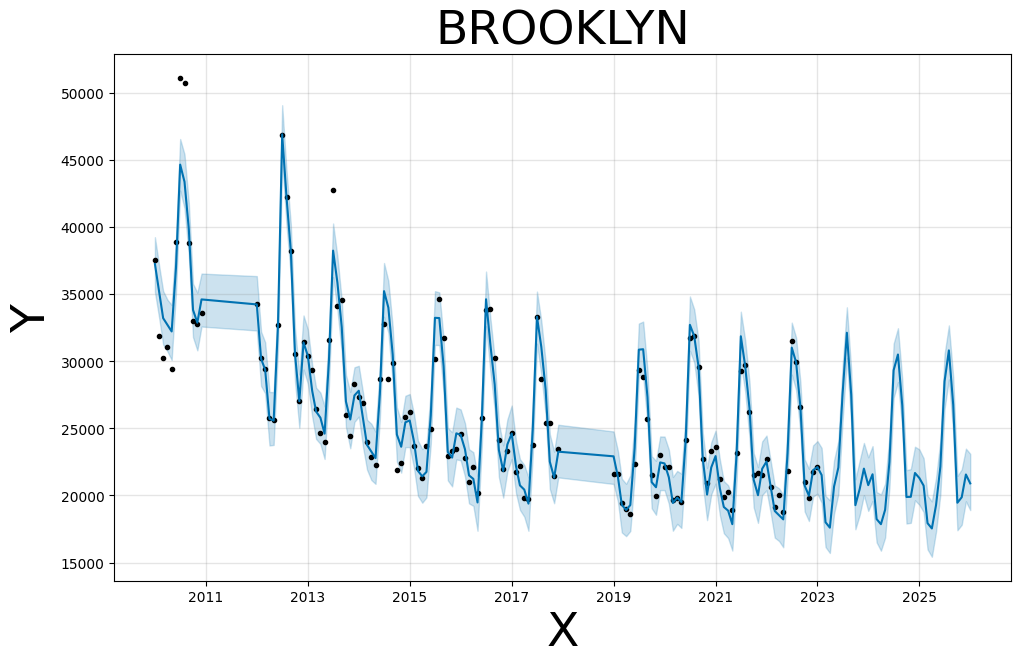

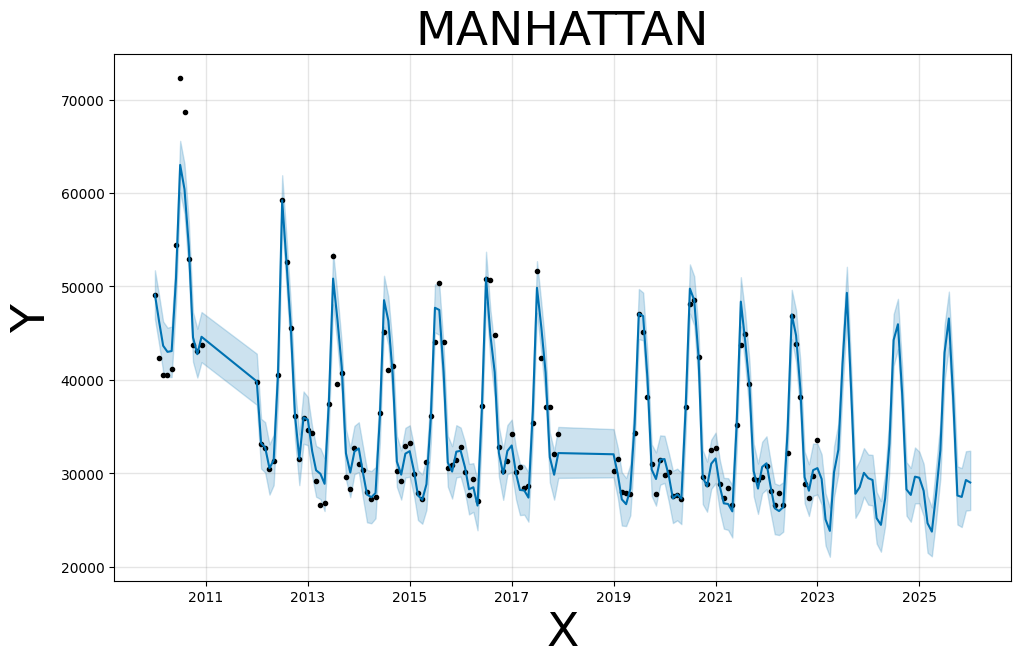

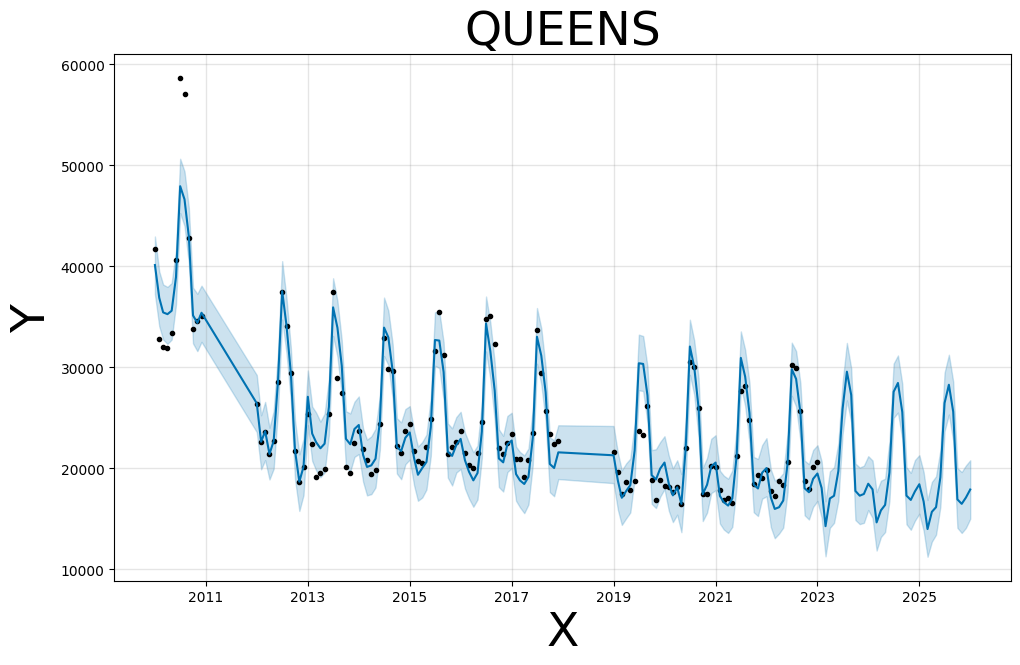

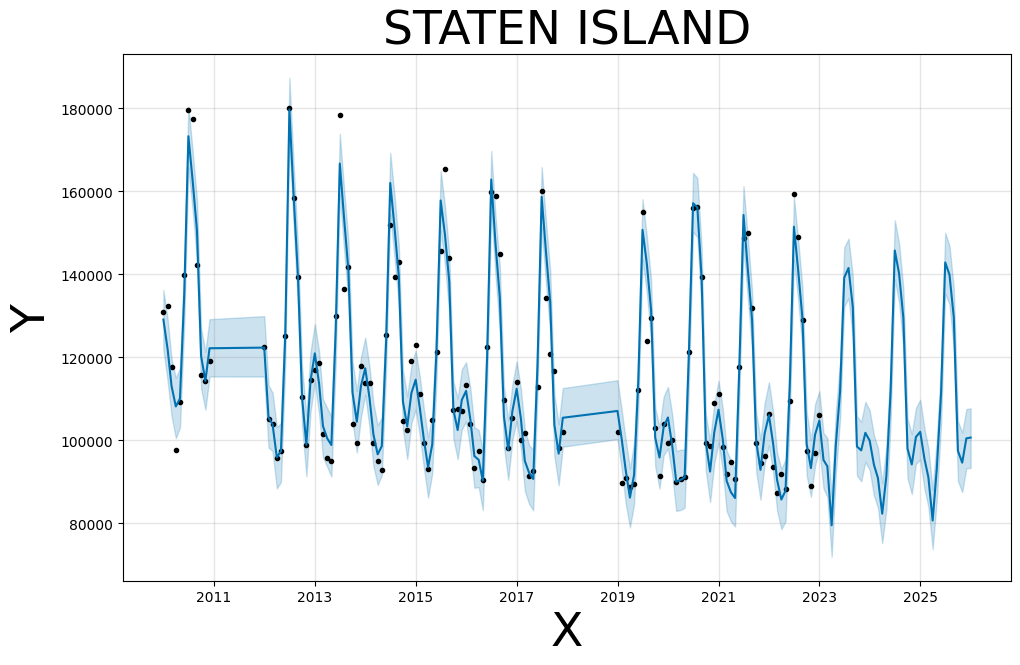

In [54]:
for borough in ['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND']:
    x = df_borough[df_borough['Borough']==borough][['y','ds']].drop_duplicates(keep='first')
    m = Prophet(holidays=lockdown_data)
    m = m.fit(x)
    future = m.make_future_dataframe(periods=12*3, freq='M') #period is in units of Months
    forecast = m.predict(future)
    fig = m.plot(forecast);
    ax = fig.gca()
    ax.set_title(borough, size=34)
    ax.set_xlabel("X", size=34)
    ax.set_ylabel("Y", size=34)